In [51]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import seaborn as sns
import pandas as pd
import numpy as np
import json
import glob
import re
import matplotlib.pyplot as plt

In [85]:
folder = "logs/04_B"

lines = []
for file_name in glob.glob("*.log", root_dir=folder):
    with open(folder + "/" + file_name) as f:
        while line := f.readline():
            if "PFSTT" in line and "dashboard is deleting returned header" not in line:
                json_string = re.search(r'PFSTT(.*?)TTSFP', line).group(1)
                try:
                    lines.append(json.loads(json_string))
                except:
                    print("Error in file: " + file_name)
                    print("Line: " + line)
                    print("JSON: " + json_string)
                    print("-----")
                    continue

df = pd.DataFrame(lines)
# Set Data Types
df["start"] = df["start"].astype(float)
df["end"] = df["end"].astype(float)
df["request_timestamp"] = df["request_timestamp"].astype(float)
df["request_deadline"] = df["request_deadline"].astype(float)

# Calculate Durations
min_timestamp = df["request_timestamp"].min()
last_experiment_timestamp = df["end"].max()
df["request_timestamp"] = df["request_timestamp"] - min_timestamp
df["request_deadline"] = df["request_deadline"] - min_timestamp
df["start"] = df["start"] - min_timestamp
df["end"] = df["end"] - min_timestamp

# Add new columns
df["run_duration"] = df["end"] - df["start"]
df["time_to_deadline"] = df["request_deadline"] - df["start"]
df["init_duration"] = df["start"] - df["request_timestamp"]
df = df.sort_values(by=["function", "start"])
df["start_diff"] = df.groupby("function")["start"].diff()
df['line_segment'] = (df['start_diff'] > 5000).cumsum() # create a new line segment if there is a 5 second break
df

,function,start,end,callid,mode,request_timestamp,request_deadline,run_duration,time_to_deadline,init_duration,start_diff,line_segment
0,check,-3.437402e+01,4.549561e+00,8e9d489d6aaa446888dcbcabbcb641e2,sync,NaN,NaN,38.923584,NaN,NaN,NaN,0
1,check,8.322942e+02,8.636609e+02,707fc39ed06341139c5eedee933bb07d,sync,NaN,NaN,31.366699,NaN,NaN,866.668213,0
2,check,1.868821e+03,1.904364e+03,1cc6b3bfe2ad45d1886ef1a54cea23ae,sync,NaN,NaN,35.542969,NaN,NaN,1036.526367,0
3,check,2.946721e+03,2.980468e+03,d51fa215e58743d99d4a22b232ea08b6,sync,NaN,NaN,33.746826,NaN,NaN,1077.900391,0
4,check,3.750801e+03,3.792396e+03,6c721c8627424b54a7d0e164b7384a6e,sync,NaN,NaN,41.595703,NaN,NaN,804.079590,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1797,virus,1.075054e+06,1.075105e+06,33b833bfaf5245c8b4a864fb606c35ac,swamped,901025.0,1081025.0,51.381836,5971.400146,174028.599854,5336.972900,221
1798,virus,1.076137e+06,1.076183e+06,29a9d5ecd42e4261a1206eefe6168282,swamped,901381.0,1081381.0,46.286621,5244.245605,174755.754395,1083.154541,221
1799,virus,1.076514e+06,1.076608e+06,f3522255a4b1401d92fd3d8f227f7244,swamped,901183.0,1081183.0,94.551270,4669.422607,175330.577393,376.822998,221
1800,virus,1.078779e+06,1.078827e+06,b72c6ee63210471d9d1adb8475ba6ea0,swamped,900499.0,1080499.0,48.035645,1720.293701,178279.706299,2265.128906,221


In [86]:
# If you want all CPU usage values in the df set this to False
ONLY_RELEVANT_CPU = True

smaller_dfs = []
for file_name in glob.glob("*.csv", root_dir="usage/"):
    # if ONLY_RELEVANT_CPU:
    #     start_ts = int(file_name.split("_")[3].split(".")[0])
    #     if start_ts > last_experiment_timestamp or start_ts < min_timestamp - 1000*60*60*24:
    #         continue
    with open("usage/" + file_name) as f:
        smaller_dfs.append(pd.read_csv(f))
usage_df = pd.concat(smaller_dfs)
usage_df["experiment_time"] = usage_df["unix_time"] - min_timestamp

if ONLY_RELEVANT_CPU:
    # Delete all values 10 seconds after the last call ended and 10 seconds before the first call started
    print("removed before:" + str(len(usage_df[usage_df["unix_time"] <= (last_experiment_timestamp + 10000)])))
    usage_df = usage_df[usage_df["unix_time"] <= (last_experiment_timestamp + 10000)]
    print("removed after:" + str(len(usage_df[usage_df["unix_time"] >= (min_timestamp - 10000)])))
    usage_df = usage_df[usage_df["unix_time"] >= (min_timestamp - 10000)]

usage_df

removed before:2160
removed after:774


,unix_time,cpu_percent,ram_percent,experiment_time
0,1695050179692,98.18,27.35,-5338.0
1,1695050181760,98.38,27.37,-3270.0
2,1695050183802,99.44,27.45,-1228.0
3,1695050185832,99.12,27.43,802.0
4,1695050187860,98.26,27.45,2830.0
...,...,...,...,...
769,1695051752677,23.70,30.86,1567647.0
770,1695051754689,22.85,30.86,1569659.0
771,1695051756699,24.06,30.82,1571669.0
772,1695051758710,24.29,30.84,1573680.0


In [87]:
min_timestamp

1695050185030.0

<Axes: xlabel='request_timestamp', ylabel='run_duration'>

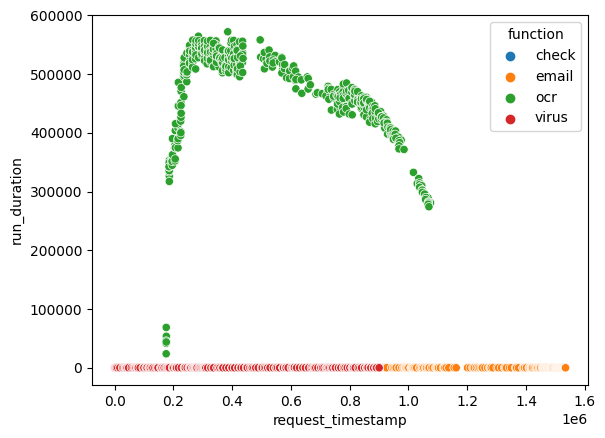

In [88]:
sns.scatterplot(data=df, x="request_timestamp", y="run_duration", hue="function")

<Axes: xlabel='request_timestamp'>

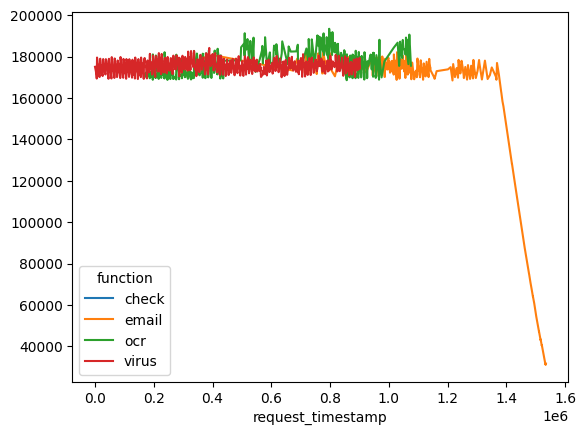

In [89]:
sns.lineplot(data=df, x="request_timestamp", y=df["start"]-df["request_timestamp"], hue="function")


<Axes: xlabel='experiment_time', ylabel='cpu_percent'>

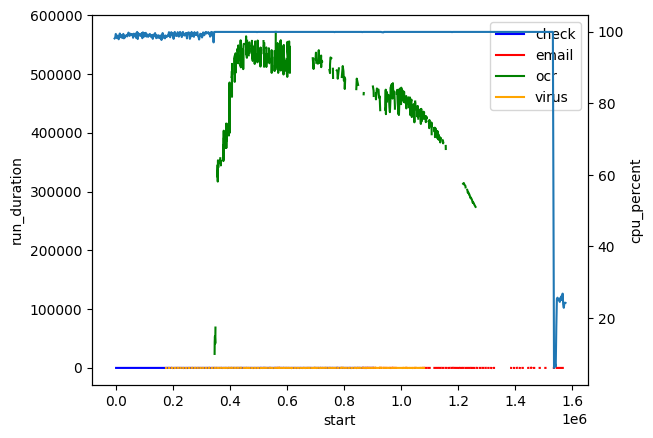

In [90]:
colors = {
    "check": "blue",
    "virus": "orange",
    "ocr": "green",
    "email": "red"
}
for (function, segment), group in df.groupby(["function", "line_segment"]):
    sns.lineplot(data=group, x="start", y="run_duration", color=colors[function], errorbar="ci", label=function, legend="brief")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
ax2 = plt.twinx()
sns.lineplot(ax=ax2, data=usage_df, x="experiment_time", y="cpu_percent")

<Axes: xlabel='experiment_time', ylabel='cpu_percent'>

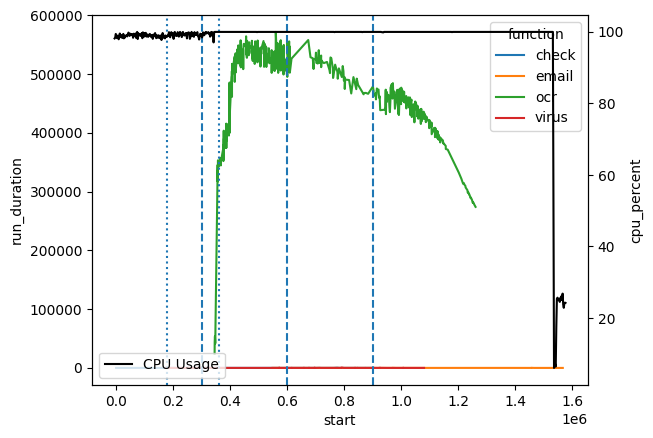

In [91]:
sns.lineplot(data=df, x="start", y="run_duration", hue="function")
plt.axvline(300_000, linestyle="dashed")
plt.axvline(600_000, linestyle="dashed")
plt.axvline(900_000, linestyle="dashed")
plt.axvline(180_000, linestyle="dotted")
plt.axvline(360_000, linestyle="dotted")
ax = plt.gca()
ax2 = plt.twinx()
sns.lineplot(ax=ax2, data=usage_df, x="experiment_time", y="cpu_percent", label="CPU Usage", color="black")


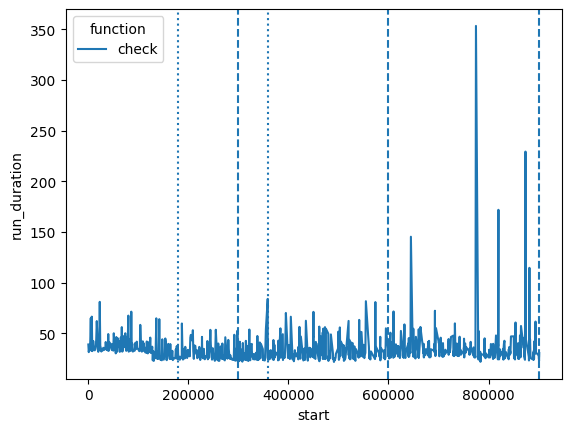

In [92]:
sns.lineplot(data=df[df["function"] == "check"], x="start", y="run_duration", hue="function")
plt.axvline(300_000, linestyle="dashed")
plt.axvline(600_000, linestyle="dashed")
plt.axvline(900_000, linestyle="dashed")
plt.axvline(180_000, linestyle="dotted")
plt.axvline(360_000, linestyle="dotted")

<Axes: xlabel='run_duration', ylabel='Proportion'>

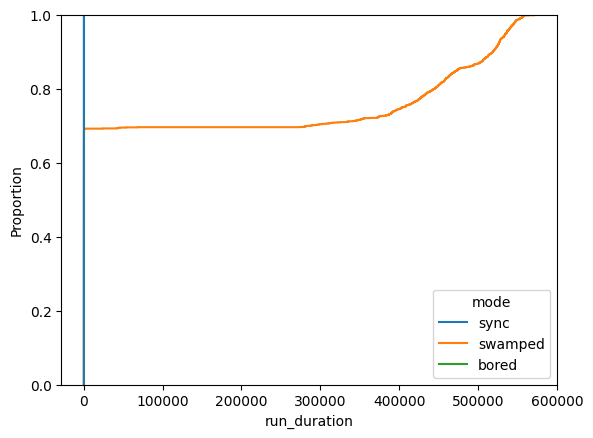

In [93]:
sns.ecdfplot(data=df, x="run_duration", hue="mode")